<a href="https://colab.research.google.com/github/mariajmolina/UMDAOSC650/blob/main/firstrnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM

An example using ONI (Oceanic Nino Index).

Let's predict a future ONI value using four previous values.

First, we will tackle a Many (4 input time steps) to One (1 future time step) framework.

Second, we will tackle a Many (4 input time steps) to Many (Y future time steps) framework. The Many-to-Many framework does not need to be Tx==Ty (but can be).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, TimeDistributed, RepeatVector
#from keras.src.preprocessing.sequence import TimeseriesGenerator # old timeseries generator
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# reading dataset from NOAA
dataset = pd.read_csv(
    'http://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt',
    sep='\s+')

In [4]:
# data features include seasons, year, total SST (C), and ONI (ENSO index)
dataset.head()

,SEAS,YR,TOTAL,ANOM
0,DJF,1950,24.72,-1.53
1,JFM,1950,25.17,-1.34
2,FMA,1950,25.75,-1.16
3,MAM,1950,26.12,-1.18
4,AMJ,1950,26.32,-1.07


In [5]:
dataset.tail()

,SEAS,YR,TOTAL,ANOM
896,ASO,2024,26.55,-0.21
897,SON,2024,26.45,-0.26
898,OND,2024,26.30,-0.37
899,NDJ,2024,26.09,-0.53
900,DJF,2025,25.99,-0.64


In [6]:
# drop any nans
dataset = dataset.dropna(subset=["ANOM"])

In [7]:
# quick stats
dataset.describe()

,YR,TOTAL,ANOM
count,901.000000,901.000000,901.000000
mean,1987.042175,26.904517,0.012908
std,21.685694,0.943686,0.836209
min,1950.000000,24.380000,-2.030000
25%,1968.000000,26.230000,-0.570000
50%,1987.000000,26.950000,-0.050000
75%,2006.000000,27.540000,0.530000
max,2025.000000,29.260000,2.640000


<Axes: xlabel='YR'>

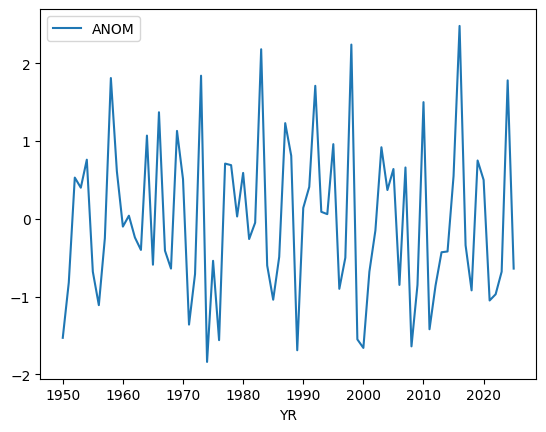

In [17]:
# quick viz
# djf only
dataset[dataset["SEAS"]=="DJF"].plot("YR","ANOM")

In [18]:
# train test split by years
trainds = dataset[dataset["YR"]<=2010]
testsds = dataset[dataset["YR"]>2010]

In [19]:
# grab anoms columns (ONI) and reset index
# reshape to be (samples, features)
# number of features here is just 1 (ONI)
trainds = trainds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)
testsds = testsds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)

In [20]:
# checking shapes -- make sure (samples, features)
print(trainds.shape, testsds.shape)

(732, 1) (169, 1)


In [21]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1))

In [22]:
# do rescaling
trainds_scaled = sc.fit_transform(trainds)
testsds_scaled = sc.transform(testsds)

# Why do we need a time series generator for RNNs?

In [229]:
# for help with data manipulation for time series rnn training; we can use the time series generator from keras

# dummy input for understanding
data = np.array([[i] for i in range(100)])

n_input=4 # the length of the input sequence
n_features=1 # the number of features

# here we are using the input to predict the next value(s) in the sequence (many-to-one)
# in other words, the input and target are the same data source
# but we don't have to deal with separating them, the generator does this for us!
inpdata = data[:-n_input]
outdata = data[n_input:]

# check shapes
print(inpdata.shape, outdata.shape)
print(inpdata[:4])
print(outdata[:4])

(96, 1) (96, 1)
[[0]
 [1]
 [2]
 [3]]
[[4]
 [5]
 [6]
 [7]]


In [230]:
# For many-to-one, we can set the timeseries generator to have different
# data and targets as below
data_gen = keras.utils.timeseries_dataset_from_array(
    data=inpdata,
    targets=outdata,
    sequence_length=4, # Length of the data sequences
    sequence_stride=5, # Period between successive output sequences
    sampling_rate=1,   # Period between successive individual timesteps (problematic if > 1)
    batch_size=3,
    shuffle=False,
    seed=1,
    start_index=None,
    end_index=None,
)

In [231]:
for batch in data_gen:
  inputs, targets = batch
  print(f"Inputs: {inputs}")
  print(f"Targets: {targets}")
  break

Inputs: [[[ 0]
  [ 1]
  [ 2]
  [ 3]]

 [[ 5]
  [ 6]
  [ 7]
  [ 8]]

 [[10]
  [11]
  [12]
  [13]]]
Targets: [[ 4]
 [ 9]
 [14]]


In [232]:
# For many-to-many, we can set the timeseries generator to have no targets

# Example1: Lx = Ly (concurrent output)
#sequence_length_inp = 4
#sequence_length_out = sequence_length_inp
#start_index_out = None
#sequence_stride = 1
#sampling_rate = 1

# Example2: Lx = Ly (input sequence, wait, output sequence)
sequence_length_inp = 4
sequence_length_out = sequence_length_inp
start_index_out = sequence_length_inp
sequence_stride = 1
sampling_rate = 1

# Example3: Lx = Ly (input sequence and slide output sequence)
#sequence_length_inp = 4
#sequence_length_out = sequence_length_inp
#start_index_out = 2
#sequence_stride = start_index_out
#sampling_rate = start_index_out

# data generators
data_gen_inp = keras.utils.timeseries_dataset_from_array(
    data=data,
    targets=None,
    sequence_length=sequence_length_inp, # Length of the data sequences
    sequence_stride=sequence_stride, # Adjust this to slide the output sequence from the input sequence
    sampling_rate=sampling_rate,   # Period between successive individual timesteps
    batch_size=2,
    shuffle=False,
    seed=1,
    start_index=None,
    end_index=None,
)

data_gen_out = keras.utils.timeseries_dataset_from_array(
    data=data,
    targets=None,
    sequence_length=sequence_length_out, # Length of the data sequences
    sequence_stride=sequence_stride, # Adjust this to slide the output sequence from the input sequence
    sampling_rate=sampling_rate,   # Period between successive individual timesteps
    batch_size=2,
    shuffle=False,
    seed=1,
    start_index=start_index_out,
    end_index=None,
)

In [233]:
# quick check of output
for inputs, outputs in zip(data_gen_inp, data_gen_out):
  print(f"Inputs: {inputs}")
  print(f"Targets: {outputs}")
  break

Inputs: [[[0]
  [1]
  [2]
  [3]]

 [[1]
  [2]
  [3]
  [4]]]
Targets: [[[4]
  [5]
  [6]
  [7]]

 [[5]
  [6]
  [7]
  [8]]]


# Many-to-One LSTM
(Process one time step at a time and only output the final hidden state)

This approach is often used when you are primarily interested in the overall context of the sequence for making a single prediction at the end.

In [266]:
# the length of the input feature
n_input = 4 # you can change this! doesn't HAVE to be 4 months input

# here goes our training data
inpdata = trainds_scaled[:-n_input]
outdata = trainds_scaled[n_input:]

n_features = 1
BATCHSIZE = 16

data_gen = keras.utils.timeseries_dataset_from_array(
    data=inpdata,
    targets=outdata,
    sequence_length=4, # Length of the data sequences
    sequence_stride=1, # Period between successive output sequences
    sampling_rate=1,   # Period between successive individual timesteps (problematic if > 1)
    batch_size=BATCHSIZE,
    shuffle=False,
    seed=1,
    start_index=None,
    end_index=None,
)

# generators make using validation_split not possible when training, we need to define one now
test_gen = keras.utils.timeseries_dataset_from_array(
    data=testsds_scaled[:-n_input],
    targets=testsds_scaled[n_input:],
    sequence_length=4, # Length of the data sequences
    sequence_stride=1, # Period between successive output sequences
    sampling_rate=1,   # Period between successive individual timesteps (problematic if > 1)
    batch_size=len(testsds_scaled[n_input:]),
    shuffle=False,
    seed=1,
    start_index=None,
    end_index=None,
)

In [267]:
# check shapes
print(inpdata.shape, outdata.shape, n_features)

(728, 1) (728, 1) 1


In [268]:
for batch in data_gen:
  inputs, targets = batch
  print(f"Inputs: {inputs[0:3]}")
  print(f"Targets: {targets[0:3]}")
  break

Inputs: [[[0.11286682]
  [0.15575621]
  [0.19638826]
  [0.19187359]]

 [[0.15575621]
  [0.19638826]
  [0.19187359]
  [0.21670429]]

 [[0.19638826]
  [0.19187359]
  [0.21670429]
  [0.26636569]]]
Targets: [[0.21670429]
 [0.26636569]
 [0.33634312]]


In [269]:
# many-to-one example
# lets make our rnn!
regressor = Sequential()

# LSTM; input shape is 1 (for one time step at a time)
# and n_features which is also 1 for our toy example
regressor.add(keras.layers.Input(shape=(1, n_features), batch_size=BATCHSIZE))

### NOTE BELOW:
# If you want to process the entire sequence at once, change the input
# shape above to (4, n_features) while keeping return_sequences=False below.

# don't return sequence; just the final hidden state
regressor.add(LSTM(units=50, return_sequences=False))

# one neuron for output prediction
regressor.add(Dense(1))
regressor.add(Activation('linear'))

# compile model
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

# what does graph look like?
regressor.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (16, 50)                    │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (16, 1)                     │              51 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (16, 1)                     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [270]:
# train the lstm!
EPOCHS = 20
history = regressor.fit(data_gen, epochs=EPOCHS, validation_data=test_gen)

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1287 - mae: 0.3080 - mse: 0.1287 - val_loss: 0.0139 - val_mae: 0.0969 - val_mse: 0.0139
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0103 - mae: 0.0789 - mse: 0.0103 - val_loss: 0.0116 - val_mae: 0.0865 - val_mse: 0.0116
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096 - mae: 0.0759 - mse: 0.0096 - val_loss: 0.0110 - val_mae: 0.0838 - val_mse: 0.0110
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092 - mae: 0.0743 - mse: 0.0092 - val_loss: 0.0105 - val_mae: 0.0818 - val_mse: 0.0105
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0089 - mae: 0.0731 - mse: 0.0089 - val_loss: 0.0102 - val_mae: 0.0804 - val_mse: 0.0102
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0087 - mae: 0.0723 - mse: 0.0087 - val_loss: 0.0099 - val_mae: 0.0792 - val_mse: 0.0099
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - mae: 0.0715 - mse: 0.0085 - val_loss: 0.0097

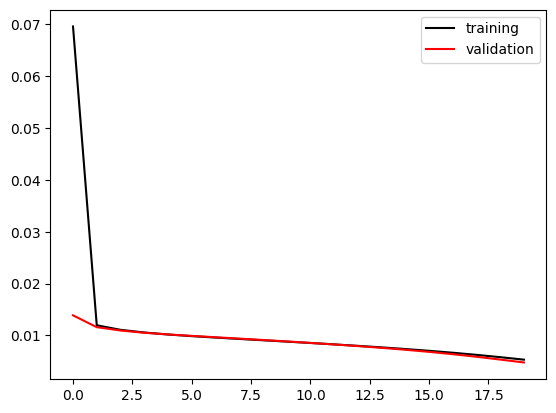

In [271]:
plt.plot(range(0,EPOCHS), history.history['loss'], c='k', label='training')
plt.plot(range(0,EPOCHS), history.history['val_loss'], c='r', label='validation')
plt.legend()
plt.show()

In [272]:
for batch in test_gen:
  _, y = batch
  print(f"Targets: {y.shape}")
  break

Targets: (162, 1)


In [273]:
# predict using test data
oni_predictions = regressor.predict(test_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


In [274]:
# quick check that we have a match of shapes
print(oni_predictions.shape, y.shape)

(162, 1) (162, 1)


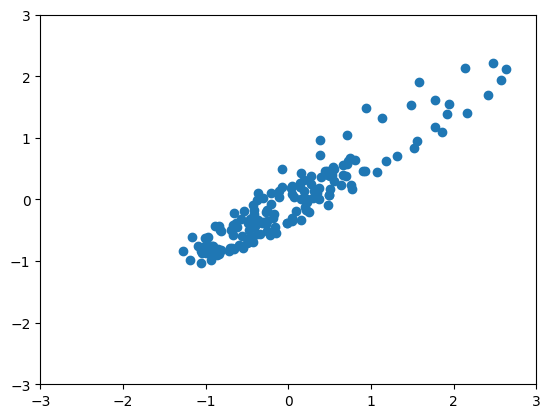

In [275]:
# how did we do!?
plt.scatter(
    sc.inverse_transform(y).reshape(-1),
    sc.inverse_transform(oni_predictions).reshape(-1)
    )
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

# Many-to-Many LSTM

In [ ]:
# redoing data preprocessing steps here more quickly

# reading dataset from NOAA online
dataset = pd.read_csv(
    'http://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt',
    delim_whitespace=True)

# drop any nans
dataset = dataset.dropna(subset=["ANOM"])

# train test split by years
trainds = dataset[dataset["YR"]<=2010]
testsds = dataset[dataset["YR"]>2010]

# grab anoms columns (ONI) and reset index
# reshape to be (samples, features)
# number of features here is just 1 (ONI)
trainds = trainds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)
testsds = testsds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)

# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1))

# do rescaling
trainds_scaled = sc.fit_transform(trainds)
testsds_scaled = sc.transform(testsds)

In [ ]:
# for help with data manipulation for time series rnn training; we can use the time series generator from keras

# dummy input for understanding
# data = np.array([[i] for i in range(50)])

# here goes our training data
data = trainds_scaled

# the shape of your target is your prediction shape
target = np.concatenate((np.roll(data, 0, axis=0),
                         np.roll(data, -1, axis=0),
                         np.roll(data, -2, axis=0),
                         #np.roll(data, -3, axis=0)
                        ), axis=1)

# the length of the input feature
n_input=4
n_features=data.shape[1]
n_pred=target.shape[1]

# this is the generator that will go into our rnn for training
data_gen = TimeseriesGenerator(data,
                               target,
                               length=n_input,
                               sampling_rate=1,
                               batch_size=16,
                               shuffle=True)

In [ ]:
# quick check of output
batch_0 = data_gen[0]
x, y = batch_0
print(x[0], y[0])
print(x.shape, y.shape, n_features)

[[0.37923251]
 [0.4717833 ]
 [0.55079007]
 [0.60948081]] [0.66591422 0.71331828 0.76749436]
(16, 4, 1) (16, 3) 1


In [ ]:
# many-to-one example

# lets make our rnn!
regressor = Sequential()

# LSTM; input shape is 1 (for one time step at a time) and n_features which is also 1 for our toy example
regressor.add(keras.layers.Input(shape=(1, n_features), batch_size=16))

# encoder is needed because we are using many to predict future manys
# return sequence
regressor.add(LSTM(units=50, return_sequences=False))

# one neuron for output prediction needs to be repeated for each future many prediction
regressor.add(RepeatVector(n_pred))

# decoder to predict; return each prediction so return_sequence=True
# return sequence
regressor.add(LSTM(units=50, return_sequences=True))

# predict 1 value per returned sequence value
regressor.add(TimeDistributed(Dense(1)))
regressor.add(Activation('linear'))

# compile model
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

# what does graph look like?
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (16, 50)                  10400     
                                                                 
 repeat_vector (RepeatVecto  (16, 3, 50)               0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (16, 3, 50)               20200     
                                                                 
 time_distributed (TimeDist  (16, 3, 1)                51        
 ributed)                                                        
                                                                 
 activation_1 (Activation)   (16, 3, 1)                0         
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 3065

In [ ]:
# train the lstm!
regressor.fit(data_gen, epochs=20)

Epoch 1/20
46/46 [==============================] - 6s 13ms/step - loss: 0.0764 - mse: 0.0764 - mae: 0.2227
Epoch 2/20
46/46 [==============================] - 1s 14ms/step - loss: 0.0258 - mse: 0.0258 - mae: 0.1262
Epoch 3/20
46/46 [==============================] - 1s 15ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.0965
Epoch 4/20
46/46 [==============================] - 1s 13ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0930
Epoch 5/20
46/46 [==============================] - 1s 14ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0954
Epoch 6/20
46/46 [==============================] - 1s 15ms/step - loss: 0.0142 - mse: 0.0142 - mae: 0.0920
Epoch 7/20
46/46 [==============================] - 1s 16ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0860
Epoch 8/20
46/46 [==============================] - 1s 19ms/step - loss: 0.0109 - mse: 0.0109 - mae: 0.0814
Epoch 9/20
46/46 [==============================] - 1s 12ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0787
Epoch 10/20
46/46 [=========

In [ ]:
# here goes our testing data
testdata = testsds_scaled

# make sure you make this match your training target
testtarget = np.concatenate((
    np.roll(testdata, 0, axis=0),
    np.roll(testdata, -1, axis=0),
    np.roll(testdata, -2, axis=0),
    #np.roll(testdata, -3, axis=0)
    ), axis=1)

testdata_gen = TimeseriesGenerator(
    testdata,
    testtarget,
    length=n_input,
    sampling_rate=1,
    batch_size=testdata.shape[0], # all samples
    shuffle=False)

In [ ]:
# quick check of output
batch_0 = testdata_gen[0]
x, y = batch_0
print(x[0], y[0])
print(x.shape, y.shape)

[[0.13769752]
 [0.18961625]
 [0.248307  ]
 [0.29345372]] [0.33408578 0.35891648 0.34988713]
(153, 4, 1) (153, 3)


In [ ]:
# make predictions
oni_predictions = regressor.predict(testdata_gen)

1/1 [==============================] - 2s 2s/step


In [ ]:
# check shapes match
print(oni_predictions.shape, y.shape)

(153, 3, 1) (153, 3)


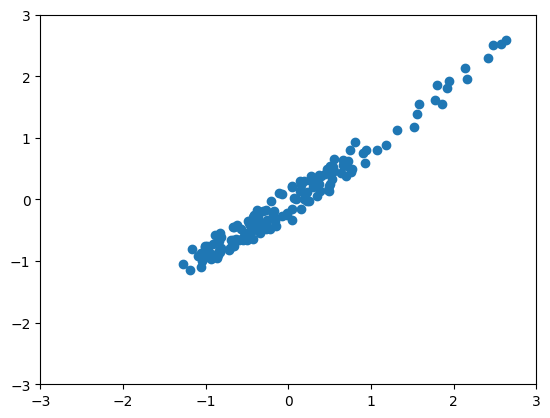

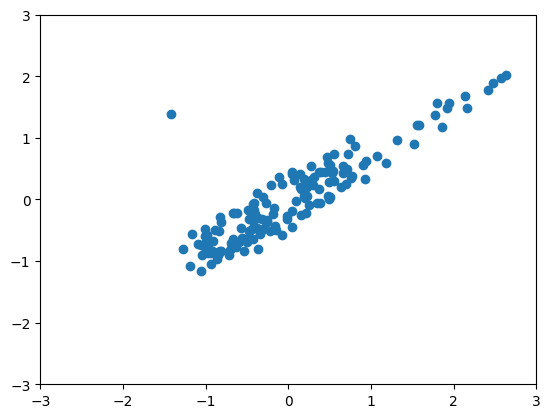

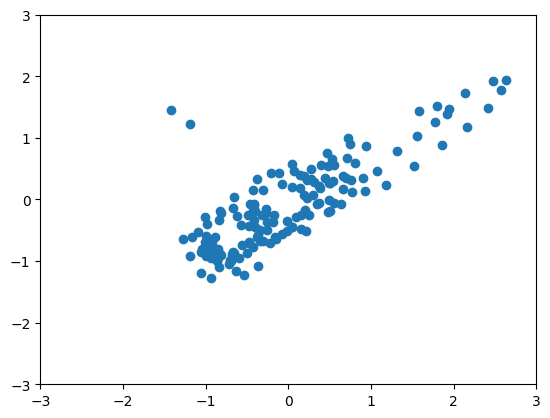

In [ ]:
for i in range(0, n_pred):
    # how did we do!?
    plt.scatter(
        sc.inverse_transform(y[:, i].reshape(-1, 1)).reshape(-1),
        sc.inverse_transform(oni_predictions[:, i].reshape(-1, 1)).reshape(-1)
        )
    plt.xlim([-3,3])
    plt.ylim([-3,3])
    plt.show()